In [1]:
import qmcpy as qp
import numpy as np
import random
import math
import time
import matplotlib.pyplot as plt
import scipy

print('okay')

okay


We want to examine Kronecker sequences in $[0,1]^d$ for Quasi-Monte Carlo integration. Kronecker sequences can be defined as 
$$
\{ x_i = (i \boldsymbol{\alpha} + \boldsymbol{\Delta}) \mod \boldsymbol{1}~ | ~i = 0, 1, 2, ...) \}
,$$

where $\boldsymbol{\alpha}, \boldsymbol{\Delta} \in [0,1)^d$. Below, we are comparing different sequences with the Kronecker sequences. By using Halton, Lattice, Digital Net base 2, and iid sequences, I wanted to see how they behave versus Kronecker sequences. We see that Kronecker sequence is a lot like Lattice sequence. The difference between both sequences is that Lattice sequence has to have a $2^m$ for $m \in \mathbb{N}$ number of samples, while Kronecker can have $n \in \mathbb{N}$ number of samples. Matter of fact, if we choose $\boldsymbol{\alpha}$ as $\boldsymbol{h} \phi_b(i)$, where $\phi_b$ is the van der Corput sequence in base b,  this would give us lattice sequence, at which can be written as 
$$
\{ x_i = ( \boldsymbol{h} \phi_b(i) + \boldsymbol{\Delta}) \mod \boldsymbol{1}~ | ~ i = 0, 1, 2, ...\},
$$
where $\boldsymbol{h}$ is the chosen $d$-dimensional integer vector, $\phi_b(i) = i_0 b^{-1} + i_1 b^{-2} + i_2 b^{-3} + ...$, and $\boldsymbol{\Delta} \in [0,1)^d$ is the shift for the lattice sequence. Notice, closely related they are compared to other sequences like iid, Halton, or Digital Net Base 2. While Halton sequence can be calculated as
$$
\{ x_i =  [ \phi_{b_1}(i), \phi_{b_2}(i), \phi_{b_3}(i),..., \phi_{b_d}(i)  ]~|~ i = 0, 1, 2, ... \},
$$
where for $b_1, b_2, b_3, ..., b_d$ are all distinct prime numbers in increasing order. And Digital Net 2 sequences can also be defined as
#Also Digital Net 2 sequences

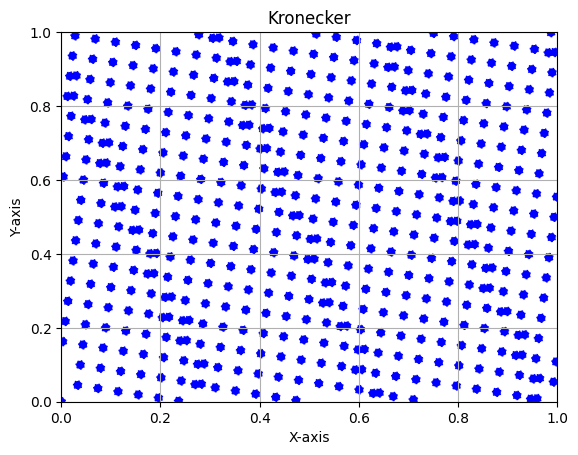

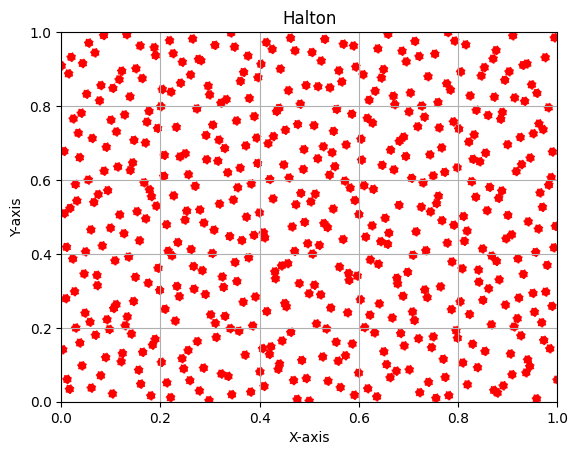

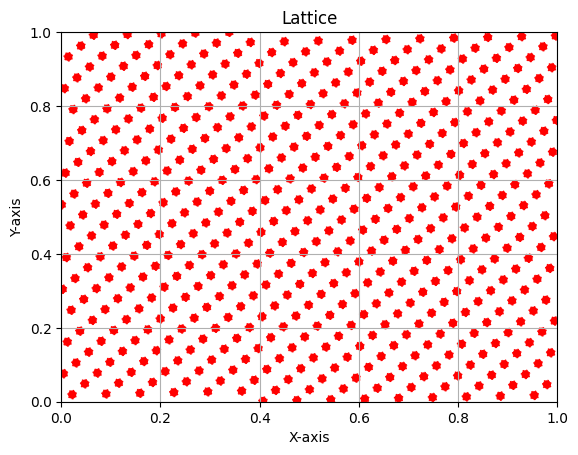

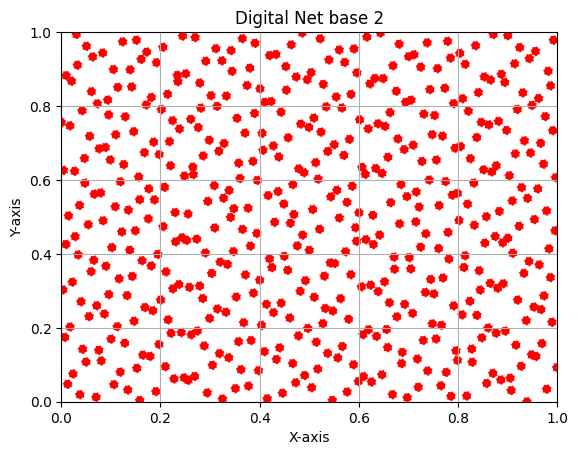

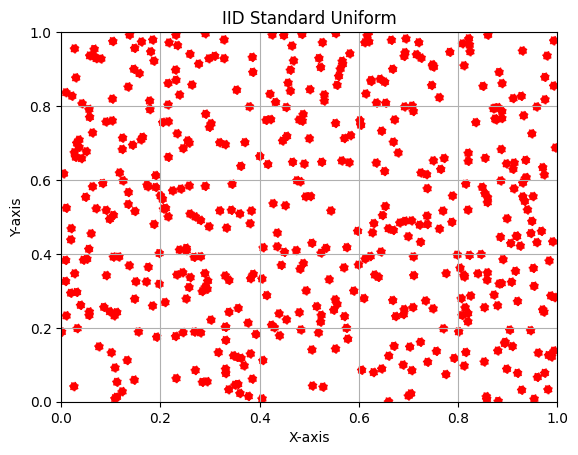

In [3]:
kronecker = qp.Kronecker(2)
K = kronecker.gen_samples(512)

halton = qp.Halton(2)
H = halton.gen_samples(512)

lattice = qp.Lattice(2)
L = lattice.gen_samples(512)

dnb2 = qp.DigitalNetB2(2)
d2 = dnb2.gen_samples(512)

dd = qp.IIDStdUniform(2)
iid = dd.gen_samples(512)

# Create a line plot
plt.scatter(K[:,0], K[:,1], color='blue', linestyle='dotted')
plt.title('Kronecker')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axis((0, 1, 0, 1))
plt.grid(True)
plt.show()

plt.scatter(H[:,0], H[:, 1], color='red', linestyle='dotted')
plt.title('Halton')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axis((0, 1, 0, 1))
plt.grid(True)
plt.show()

plt.scatter(L[:,0], L[:, 1], color='red', linestyle='dotted')
plt.title('Lattice')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axis((0, 1, 0, 1))
plt.grid(True)
plt.show()

plt.scatter(d2[:,0], d2[:, 1], color='red', linestyle='dotted')
plt.title('Digital Net base 2')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axis((0, 1, 0, 1))
plt.grid(True)
plt.show()

plt.scatter(iid[:,0], iid[:, 1], color='red', linestyle='dotted')
plt.title('IID Standard Uniform')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axis((0, 1, 0, 1))
plt.grid(True)
plt.show()

From our paper, we want to calculated the weighted sum squared discrepancy. To get our best possible choice for $\boldsymbol{\alpha}$, we need to choose whichever choice of randomly generated $\boldsymbol{\alpha}$ that would give the least weighted sum squared discrepancy. To get weighted sum squared discrepancy, we calculate 
$$
WSSD = \widetilde{K}(0) b_N(0) + 2 \sum_{k=1}^{N-1} b_N(k) \widetilde{K}(k \boldsymbol{\alpha} \mod \boldsymbol{1}) - \beta_N \int_{[0,1]} \widetilde{K}(\boldsymbol{t})~d \boldsymbol{t},
$$
where $\beta_N = \sum_{n=1}^N w_n$ and $b_N(k) = \sum_{n= k+1}^N w_n(n-k) / (n^2)$. Note, $b_N(k)$ can be rewritten as 
$$
b_N(k) = b_N(k+1) + \widetilde{b}_N(k+1) + \frac{w_{k+1}}{(k+1)^2}
$$ 
for $k = N-2, N-3, ..., 0$ where $\widetilde{b}_N(k+1) = \sum_{n=k+2}^N (w_n) /(n^2)$. Of course, $\widetilde{b}_N(N-1) = b_N(N-1) = \frac{w_n}{N^2}$ and 
$$
\widetilde{b}_N(k) = \sum_{n=k+1}^N \frac{w_n}{n^2} = \widetilde{b}_N(k+1) + \frac{w_{k+1}}{(k+1)^2}.
$$
For simplicity, we can let $\hat{b}(k) = w_k /(k^2)$ given by the paper.

#The last 3 equations on page 4 look at that for the program.

In [41]:
def wtdsumsqdisckron(alphamat, dimension, sample, n = 50, Time = False, discwt = None,coordwts = np.arange(1,51).reshape((50, 1))):
    start_time = time.time()
    n_al = np.size(alphamat)
    d = dimension
    #Use numpy's shape function to find dimension d and the different number of samples for alpha in [0,.5)^d
    coordwts = coordwts[0:d]
    #Makes sure we don't have extra values for coordinate weights
    if discwt == None:
        Discwt = np.arange(1,n+1).reshape((n, 1))
        #If discwt was not specified. Go ahead with the calculation.
    else:
        Discwt = discwt(n)
    #Need to find beta, which is to take the sum of Discwt.
    beta = np.sum(Discwt)
    squared = (np.arange(1,n+1).reshape((n, 1)))**2 
    #To find bhat, for each element take Discwt / squared.
    bhat = Discwt / squared
    #Unlike Matlab, in python to reverse the order of bhat, we have to use np.flip
    #As python's cumsum is different from Matlab's cumsum, as 1 goes 1 way while
    #the other goes in the opposite direction which is why I flipped it again.
    btilde = np.cumsum(np.flip(bhat))
    btilde = np.flip(btilde)
    #Use np.squeeze to minimize the size of btilde and to do the np.flip appropraiately
    A = np.flip(np.squeeze(btilde))
    A[1:n] = A[0:n-1]
    A[0] = 0
    #For the 3 lines of code above, when playing with the matlab code, you shift each element in the array
    #by 1 towards the end. However, the first element must be 0.
    btilde = A + np.flip(np.squeeze(bhat))
    b = np.flip(np.cumsum(btilde))
    #To calculate b, you have to use cumsum and then flip it due to the fact that it's not in the right
    #order based off of the Matlab code while converting it
    kronecker= qp.Kronecker(alpha = alphamat)
    xkron = kronecker.gen_samples(n)
    #I had to redesign kronecker, so that it can deal with multiple choices of alpha.
    kernelkron = (1 + (0.5*coordwts[d-1]*(xkron*(xkron-1) + 1/6)))
    kernelkron = sample.reshape((n,1))*kernelkron
    wssd = -1*beta
    wssd = wssd + b[0]*kernelkron[0,:] + 2*np.sum(b[1:n].reshape((n-1, 1))*kernelkron[1:n, :],0)
    #In case you are interested in runtime in seconds for future use if we want to fasten the runtime.
    end_time = time.time()
    if Time == True:
        total_time = end_time - start_time
        return [wssd,xkron,b, bhat, btilde, kernelkron, total_time]
    else:
        return [wssd,xkron,b, bhat, btilde, kernelkron]

I made certain decisions on what features we should have within the function itself.
The parameters this function will take are:

i.) $alphamat$ - A $(d \times n_{\alpha})$ 2D matrix where $d$ is the dimensions of $\boldsymbol{\alpha}$ and $n_{\alpha}$ is the amount samples of $\boldsymbol{\alpha}$. And this is required.

ii.) $n$ - being the number of samples for the Kronecker sequence. And this is also required.

iii.) $Time$ - set True if you want to record runtime (s) and False if you don't. In case, if you wanted to know the runtime in running the compuatation.

iv.) $limiter$ - limiter is the parameter to keep the computer from running too many computations at once and be overwhelmed or run out of memory.

v.) $discwt$ - That is the $w_n$ for the equation we have above.

vi.) $coordwts$ - The weights for each coordinate for the Kernels.

As for what the function gives out:

i.) $wssd$ - This will give the weighted sum squared discrepancy for each choice of $\boldsymbol{\alpha}$. 

ii.) $xkron$ - This is a $(n \times d \times n_{\alpha})$ 3D matrix where the first dimension is based on the sequence per choice of $\boldsymbol{\alpha} \in [0,1]^d$.

iii.) $b$ - From the equation to calculate $WSSD$, it will give you $b(k)$ for $k = 1, 2, 3, ..., N-1$.

iv.) $bhat$ - This will give out the $\hat{b}(k)$ as calculated from what we have above for $k = N, N-1, N-2, ..., 1$.

v.) $btilde$ - This will give you $\widetilde{b}(k)$ for $k = N-2, N-3, ..., 0$ for the weighted sum squared discrepancy.

vi.) $total~time$ - This will give you the total runtime in seconds, in case you needed the runtime. Only outputs this if Time variable in the input of the weighted sum squared discrepancy function is True.

To generate Kronecker points, we need 3 things which are the number of sample points, $\boldsymbol{\alpha} \in [0,1]^d$ and the dimensions $d$. We have to think intuitively of what we want. Recall Kronecker sequences are generated as $\{ x_i = (i \boldsymbol{\alpha} + \boldsymbol{\Delta}) \mod \boldsymbol{1} | \boldsymbol{\alpha}, \boldsymbol{\Delta} \in [0,1]^d, i = 0, 1, 2, ...) \}$. I prefer if we have 3 dimensions. A dimension for each choice of $n_\alpha$, another dimension based upon the length of $\boldsymbol{\alpha} \in [0,1]^d$ at which would be at length of $d \in \mathbb{N}$, and $n$ which is the number of samples we want.

There wasn't much of any features needed in this function as it is pretty simple what we want. However, I still think it is a good idea to explain the parameters needed for the function. This function will give a 3D Matrix in the shape of $(n \times d \times n_{\alpha})$ that generates a sequence of points using multiple choices of $\boldsymbol{\alpha}, \boldsymbol{\Delta} \in [0,1]^d$. Since to get Kronecker sequence, we have to calculate $\{ x_i = (i \boldsymbol{\alpha} + \boldsymbol{\Delta}) \mod 1 \}$. Of course our paramter $alpha$ should be set such that
$$
alpha =
\begin{bmatrix}
\boldsymbol{\alpha}_1 & \boldsymbol{\alpha}_2 & \boldsymbol{\alpha}_3 & ... & \boldsymbol{\alpha}_{n_\alpha}
\end{bmatrix}
$$
At which for $\boldsymbol{\alpha}_j \in [0,1]^d$ for $j = 1, 2, 3, ..., n_\alpha$. We can rewrite $alphamat$ to be
$$
alpha = 
\begin{bmatrix}
\alpha_{(1,1)} & \alpha_{(1,2)} & \alpha_{(1,3)} & ... & \alpha_{(1,n_\alpha)}\\
\alpha_{(2,1)} & \alpha_{(2,2)} & \alpha_{(2,3)} & ... & \alpha_{(2,n_\alpha)}\\
\alpha_{(3,1)} & \alpha_{(3,2)} & \alpha_{(3,3)} & ... & \alpha_{(3,n_\alpha)}\\
... & ... & ... & ... & ... \\
\alpha_{(d,1)} & \alpha_{(d,2)} & \alpha_{(d,3)} & ... & \alpha_{(d, n_\alpha)}
\end{bmatrix}
$$

For $\alpha_{(i,j)} \in [0,1]$ for $i = 1, 2, 3, ..., d$. The parameter $delta$ is our shifting vector at which $\boldsymbol{\Delta} \in [0,1]^d$. Our variable $n$ is the number of samples we want for the Kronecker sequence. I left it as an option, because of the fact that there are cases where you don't need $\boldsymbol{\Delta}$. In case for future use, I just set $delta$ as 0.

We want to make a function that would generate the best choice for the Kronecker sequence. Of course, we have what we need. To get our best choice $\boldsymbol{\alpha} \in [0,1]^d$ there are some manipulation, we can be useful here. First off, from using Kronecker Symmetric Theorem if we were to replace one of the elements in $\boldsymbol{\alpha}$ from $\alpha_\ell$ to $1 - \alpha_\ell$ for any $\ell = 1, 2, 3, ... , d$. This could be manipulated such that we can minimize the volume for finding an good choice for $\boldsymbol{\alpha}$ by going from $[0,1]^d$ to $[0, .5]^d$. Of course, we got to keep in mind the parameters for the weighted sum squared discrepancy function. The idea behind choosing the best $\boldsymbol{\alpha}$ in high dimensions is to do a search by search for each dimension. What I mean by this is:

Step 1.) Find a good choice for $\alpha_1$ dealing with the first dimension. 

Step 2.) Fix that choice for $\alpha_1$ for the first dimension by finding the $\alpha_1$ that gives the minimum weighted sum sqaured discrepancy.

Step 3.) Expand to the next dimension and repeat steps 1 and 2 until you get to the last dimension.

So instead of looking at $(n_\alpha)^d$ possible choices for the best $\boldsymbol{\alpha}$, we are looking at $d * n_\alpha$ which is better than $(n_\alpha)^d$.

In [35]:
def alpha_generate(d, n_al, n, rd = None, discw = None, coordw = np.ones(50)):
    #rd serves as a randomization seed like in Halton, Lattice, and IID Uniform.
    total = 0
    best_sample = np.ones(n)
    alphabest = np.array([])
    for i in range(d):
        np.random.seed(rd)
        alphamat = (np.arange(n_al)+np.random.rand(n_al))/(2*n_al)
        #Had it range from [0,.5)^d instead of [0,1)^d, because of the fact that if we choose alpha in [0,1)^d,
        #then we can show that by taking $1- alpha$ the discrepancy with the Bernoulli polynomial kernal stays
        #the same, so it would make better sense to choose alpha in [0,.5)^d.
        [wssd,xkron,b, bhat, btilde, samples, runtime] = wtdsumsqdisckron(alphamat, i+1, best_sample, n, Time = True, discwt = discw, coordwts = coordw)
        #Goes ahead and calculates discrepancy per choice of alpha in [0,.5)^d
        indice = np.argmin(wssd)
        #Finds the element with the smallest discrepancy, as finding the minimum is vital. However, we don't
        #need the minimum itself. Just the argmin out of the choices for n_al samples of alpha.
        alphabest = np.append(alphabest, alphamat[indice])
        best_sample = samples[:, indice]
        #Gets the best choice for alpha for that dimension and then in the line below, replaces all the 
        #elements in the i-th dimension with the chosen alphabest based upon the argmin algorithm.
        total = total + runtime
    return [alphabest, min(wssd), total]

This is a further expansion of the weighted sum squared discrepancy function. The added parameters we used is $rd$ which is the randomization seed in case we want to examine if the calculations for whatever you need is doing the right steps. Parameter $d$ is the amount of dimensions for $\boldsymbol{\alpha}$ you want to generate. Likewise with $n_\alpha$ and $n$, just that $n_\alpha$ is the number of choices you want and $n$ is the number of samples you want for the Kronecker sequence.

As for manipulating $\boldsymbol{\alpha} \in [0, .5]^d$, we have 2 options.

Option 1: We program $\boldsymbol{\alpha}$ in a way such that it guarantees being in $[0, .5]^d$ without there being a checking system.

Option 2: We program $\boldsymbol{\alpha} \in [0,1]^d$ but we create a for loop such that if one of the $\alpha_\ell$ for $\ell = 1, 2, ..., d$ is greater than $.5$ then we take $1 - \alpha_\ell$.

I went ahead and went with Option 1, because Option 2 would require more runtime.

In [42]:
[alpha_choice, wssd, runtime] = alpha_generate(10, 5000, 1000) #generates a choice for alpha in a 
print(alpha_choice)
print(runtime)
n = 1000
k = n- np.arange(n-1).reshape((n-1, 1)) -1
kron = qp.Kronecker(alpha = alpha_choice)
xkron = kron.gen_samples(n)

Kernel = np.prod((1 + (0.5*(xkron*(xkron-1) + 1/6))),1)

print(np.sqrt(np.sum((n*Kernel[0]) + (2*np.sum(k*Kernel[1:n],0)))*(n**(-2)) - 1))

[0.38206889 0.27427542 0.40805399 0.4645112  0.31336783 0.16975035
 0.12158713 0.35060911 0.43001904 0.47526861]
4.513515949249268
31.601100756424437


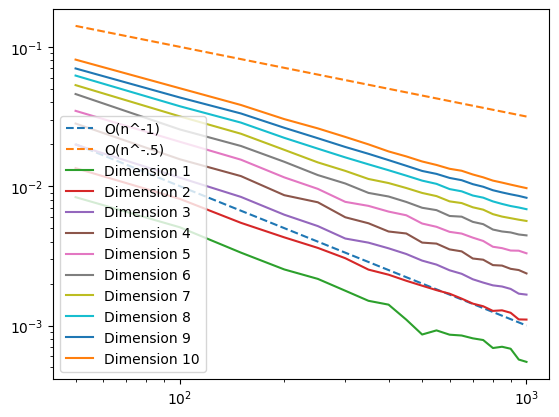

-0.9223737968616268


In [7]:
[alpha_choice, wssd, runtime] = alpha_generate(10, 5000, 1000, coordw = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])) #generates a 5 dimensional choice for alpha

x = np.array([50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000])
#I chose my x to be from 50 to 1000 in increments of 50 as they will represent the number of samples n
y_one = 1/x
#The 1/x is for O(n^{-1})
y_half = 1/np.sqrt(x)
#This 1/sqrt(x) is for O(n^{-.5})
dim_1 = np.array([])
dim_2 = np.array([])
dim_3 = np.array([])
dim_4 = np.array([])
dim_5 = np.array([])
dim_6 = np.array([])
dim_7 = np.array([])
dim_8 = np.array([])
dim_9 = np.array([])
dim_10 = np.array([])
#initializing dims 1 to 5 as they will be used to record discrepancy for n samples

for d in range(1,11):
    for n in range(50, 1001, 50):
        alphamat = alpha_choice[:d]
            
        xkron = kronecker(n, alphamat)
        Kernel = np.prod((1 + (0.5*(xkron*(xkron-1) + 1/6))),2)
        k = n- np.arange(n-1).reshape((n-1, 1)) -1
            
        discrepancy = np.sqrt(np.sum((n*Kernel[0,:]) + (2*np.sum(k*Kernel[1:n,:],0)))*(n**(-2)) - 1)
        if d == 1:
            dim_1 = np.append(dim_1, discrepancy)
        elif d == 2:
            dim_2 = np.append(dim_2, discrepancy)
        elif d == 3:
            dim_3 = np.append(dim_3, discrepancy)
        elif d == 4:
            dim_4 = np.append(dim_4, discrepancy)
        elif d == 5:
            dim_5 = np.append(dim_5, discrepancy)
        elif d == 6:
            dim_6 = np.append(dim_6, discrepancy)
        elif d == 7:
            dim_7 = np.append(dim_7, discrepancy)
        elif d == 8:
            dim_8 = np.append(dim_8, discrepancy)
        elif d == 9:
            dim_9 = np.append(dim_9, discrepancy)
        elif d == 10:
            dim_10 = np.append(dim_10, discrepancy)

plt.figure()
plt.loglog(x, y_one, label = "O(n^-1)", linestyle = '--')
plt.loglog(x, y_half, label = "O(n^-.5)", linestyle = '--')
plt.loglog(x, dim_1, label = "Dimension 1")
plt.loglog(x, dim_2, label = "Dimension 2")
plt.loglog(x, dim_3, label = "Dimension 3")
plt.loglog(x, dim_4, label = "Dimension 4")
plt.loglog(x, dim_5, label = "Dimension 5")
plt.loglog(x, dim_6, label = "Dimension 6")
plt.loglog(x, dim_7, label = "Dimension 7")
plt.loglog(x, dim_8, label = "Dimension 8")
plt.loglog(x, dim_9, label = "Dimension 9")
plt.loglog(x, dim_10, label = "Dimension 10")
plt.legend()
plt.show()
X = np.log(np.array(x))
Y = np.log(dim_1)
m, b = np.polyfit(X, Y, 1)
print(m)

[-0.86186458 -1.04451048 -1.08248033 -1.10548174 -1.19489564 -1.25061957
 -1.3476149  -1.38878244 -1.47760594 -1.49724207]


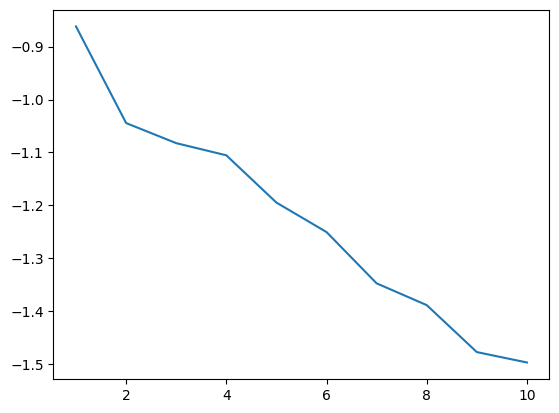

In [8]:
y = np.array([])
X = np.log(np.array(x))
Y_1 = np.log(np.array(dim_1))
Y_2 = np.log(np.array(dim_2))
Y_3 = np.log(np.array(dim_3))
Y_4 = np.log(np.array(dim_4))
Y_5 = np.log(np.array(dim_5))
Y_6 = np.log(np.array(dim_6))
Y_7 = np.log(np.array(dim_7))
Y_8 = np.log(np.array(dim_8))
Y_9 = np.log(np.array(dim_9))
Y_10 = np.log(np.array(dim_10))
m, b = np.polyfit(X, Y_1, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_2, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_3, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_4, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_5, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_6, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_7, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_8, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_9, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_10, 1)
y = np.append(y, np.array([m]))
print(np.log(-1*(y+.5)))
X_dim = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.figure()
plt.plot(X_dim, np.log(-1*(y+.5)))
plt.show()

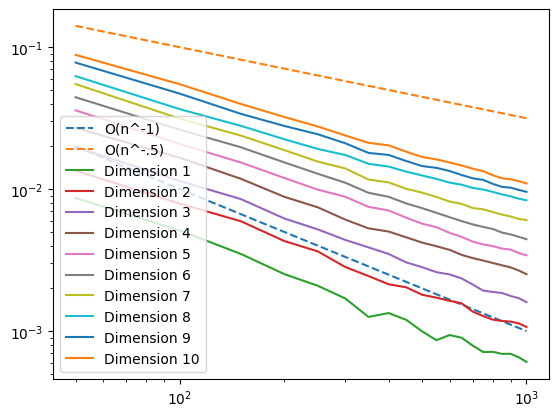

-0.9101884396108704


In [9]:
[alpha_choice, wssd, runtime] = alpha_generate(10, 5000, 1000, coordw = np.array([1, 1/4, 1/9, 1/16, 1/25, 1/36, 1/49, 1/64, 1/81, 1/100, 1/121])) #generates a 5 dimensional choice for alpha

x = np.array([50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000])
#I chose my x to be from 50 to 1000 in increments of 50 as they will represent the number of samples n
y_one = 1/x
#The 1/x is for O(n^{-1})
y_half = 1/np.sqrt(x)
#This 1/sqrt(x) is for O(n^{-.5})
dim_1 = np.array([])
dim_2 = np.array([])
dim_3 = np.array([])
dim_4 = np.array([])
dim_5 = np.array([])
dim_6 = np.array([])
dim_7 = np.array([])
dim_8 = np.array([])
dim_9 = np.array([])
dim_10 = np.array([])
#initializing dims 1 to 5 as they will be used to record discrepancy for n samples

for d in range(1,11):
    for n in range(50, 1001, 50):
        alphamat = alpha_choice[:d]
            
        xkron = kronecker(n, alphamat)
        Kernel = np.prod((1 + (0.5*(xkron*(xkron-1) + 1/6))),2)
        k = n- np.arange(n-1).reshape((n-1, 1)) -1
            
        discrepancy = np.sqrt(np.sum((n*Kernel[0,:]) + (2*np.sum(k*Kernel[1:n,:],0)))*(n**(-2)) - 1)
        if d == 1:
            dim_1 = np.append(dim_1, discrepancy)
        elif d == 2:
            dim_2 = np.append(dim_2, discrepancy)
        elif d == 3:
            dim_3 = np.append(dim_3, discrepancy)
        elif d == 4:
            dim_4 = np.append(dim_4, discrepancy)
        elif d == 5:
            dim_5 = np.append(dim_5, discrepancy)
        elif d == 6:
            dim_6 = np.append(dim_6, discrepancy)
        elif d == 7:
            dim_7 = np.append(dim_7, discrepancy)
        elif d == 8:
            dim_8 = np.append(dim_8, discrepancy)
        elif d == 9:
            dim_9 = np.append(dim_9, discrepancy)
        elif d == 10:
            dim_10 = np.append(dim_10, discrepancy)

plt.figure()
plt.loglog(x, y_one, label = "O(n^-1)", linestyle = '--')
plt.loglog(x, y_half, label = "O(n^-.5)", linestyle = '--')
plt.loglog(x, dim_1, label = "Dimension 1")
plt.loglog(x, dim_2, label = "Dimension 2")
plt.loglog(x, dim_3, label = "Dimension 3")
plt.loglog(x, dim_4, label = "Dimension 4")
plt.loglog(x, dim_5, label = "Dimension 5")
plt.loglog(x, dim_6, label = "Dimension 6")
plt.loglog(x, dim_7, label = "Dimension 7")
plt.loglog(x, dim_8, label = "Dimension 8")
plt.loglog(x, dim_9, label = "Dimension 9")
plt.loglog(x, dim_10, label = "Dimension 10")
plt.legend()
plt.show()
X = np.log(np.array(x))
Y = np.log(dim_1)
m, b = np.polyfit(X, Y, 1)
print(m)

[-0.91018844 -0.87483644 -0.85208274 -0.79806709 -0.79435922 -0.77914843
 -0.73737705 -0.65643466 -0.6941228  -0.69354015]


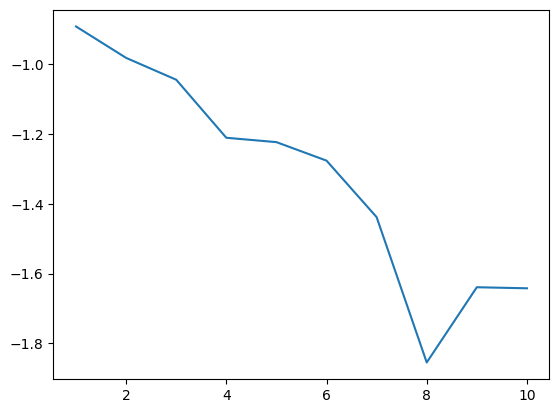

-0.09792957121954303
-0.781432644542754


In [10]:
y = np.array([])
Y_1 = np.log(np.array(dim_1))
Y_2 = np.log(np.array(dim_2))
Y_3 = np.log(np.array(dim_3))
Y_4 = np.log(np.array(dim_4))
Y_5 = np.log(np.array(dim_5))
Y_6 = np.log(np.array(dim_6))
Y_7 = np.log(np.array(dim_7))
Y_8 = np.log(np.array(dim_8))
Y_9 = np.log(np.array(dim_9))
Y_10 = np.log(np.array(dim_10))
m, b = np.polyfit(X, Y_1, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_2, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_3, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_4, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_5, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_6, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_7, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_8, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_9, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_10, 1)
y = np.append(y, np.array([m]))
X_dim = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
print(y)
plt.figure()
plt.plot(X_dim, np.log(-1*(y+.5)))
plt.show()
m, b = np.polyfit(X_dim, np.log(-1*(y+.5)), 1)
print(m)
print(b)

In [11]:
slope_m = np.array([])
y_intercept = np.array([])
for i in range(200):
    [alpha_choice, wssd, runtime] = alpha_generate(10, 5000, 1000, coordw = np.array([1, 1/4, 1/9, 1/16, 1/25, 1/36, 1/49, 1/64, 1/81, 1/100, 1/121])) #generates a 5 dimensional choice for alpha

    x = np.array([50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000])
    #I chose my x to be from 50 to 1000 in increments of 50 as they will represent the number of samples n
    y_one = 1/x
    #The 1/x is for O(n^{-1})
    y_half = 1/np.sqrt(x)
    #This 1/sqrt(x) is for O(n^{-.5})
    dim_1 = np.array([])
    dim_2 = np.array([])
    dim_3 = np.array([])
    dim_4 = np.array([])
    dim_5 = np.array([])
    dim_6 = np.array([])
    dim_7 = np.array([])
    dim_8 = np.array([])
    dim_9 = np.array([])
    dim_10 = np.array([])
    #initializing dims 1 to 5 as they will be used to record discrepancy for n samples
    
    for d in range(1,11):
        for n in range(50, 1001, 50):
            alphamat = alpha_choice[:d]
                
            xkron = kronecker(n, alphamat)
            Kernel = np.prod((1 + (0.5*(xkron*(xkron-1) + 1/6))),2)
            k = n- np.arange(n-1).reshape((n-1, 1)) -1
                
            discrepancy = np.sqrt(np.sum((n*Kernel[0,:]) + (2*np.sum(k*Kernel[1:n,:],0)))*(n**(-2)) - 1)
            if d == 1:
                dim_1 = np.append(dim_1, discrepancy)
            elif d == 2:
                dim_2 = np.append(dim_2, discrepancy)
            elif d == 3:
                dim_3 = np.append(dim_3, discrepancy)
            elif d == 4:
                dim_4 = np.append(dim_4, discrepancy)
            elif d == 5:
                dim_5 = np.append(dim_5, discrepancy)
            elif d == 6:
                dim_6 = np.append(dim_6, discrepancy)
            elif d == 7:
                dim_7 = np.append(dim_7, discrepancy)
            elif d == 8:
                dim_8 = np.append(dim_8, discrepancy)
            elif d == 9:
                dim_9 = np.append(dim_9, discrepancy)
            elif d == 10:
                dim_10 = np.append(dim_10, discrepancy)
    print(i)
    y = np.array([])
    Y_1 = np.log(np.array(dim_1))
    Y_2 = np.log(np.array(dim_2))
    Y_3 = np.log(np.array(dim_3))
    Y_4 = np.log(np.array(dim_4))
    Y_5 = np.log(np.array(dim_5))
    Y_6 = np.log(np.array(dim_6))
    Y_7 = np.log(np.array(dim_7))
    Y_8 = np.log(np.array(dim_8))
    Y_9 = np.log(np.array(dim_9))
    Y_10 = np.log(np.array(dim_10))
    m, b = np.polyfit(X, Y_1, 1)
    y = np.append(y, np.array([m]))
    m, b = np.polyfit(X, Y_2, 1)
    y = np.append(y, np.array([m]))
    m, b = np.polyfit(X, Y_3, 1)
    y = np.append(y, np.array([m]))
    m, b = np.polyfit(X, Y_4, 1)
    y = np.append(y, np.array([m]))
    m, b = np.polyfit(X, Y_5, 1)
    y = np.append(y, np.array([m]))
    m, b = np.polyfit(X, Y_6, 1)
    y = np.append(y, np.array([m]))
    m, b = np.polyfit(X, Y_7, 1)
    y = np.append(y, np.array([m]))
    m, b = np.polyfit(X, Y_8, 1)
    y = np.append(y, np.array([m]))
    m, b = np.polyfit(X, Y_9, 1)
    y = np.append(y, np.array([m]))
    m, b = np.polyfit(X, Y_10, 1)
    y = np.append(y, np.array([m]))
    X_dim = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    m, b = np.polyfit(X_dim, np.log(-1*(y+.5)), 1)
    slope_m = np.append(slope_m, np.array([m]))
    y_intercept = np.append(y_intercept, np.array([b]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [12]:
print(np.mean(slope_m))
print(np.mean(y_intercept))
print(scipy.stats.ttest_1samp(slope_m, -.0978,alternative='two-sided'))
print(scipy.stats.ttest_1samp(y_intercept, -.7872,alternative='two-sided'))

-0.09805958480402449
-0.7881992949205437
Ttest_1sampResult(statistic=-0.16502955041268474, pvalue=0.8690882422862201)
Ttest_1sampResult(statistic=-0.15935425426092156, pvalue=0.8735513953312832)


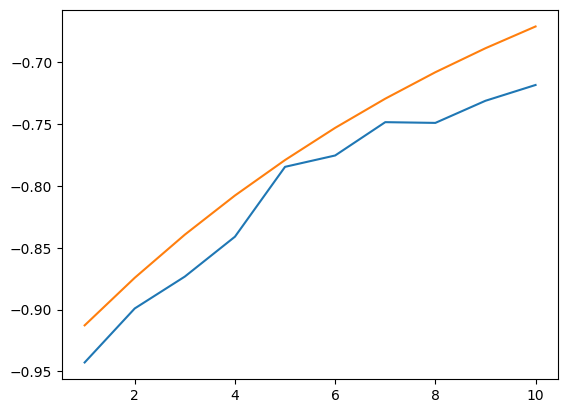

In [13]:
y = np.array([])
Y_1 = np.log(np.array(dim_1))
Y_2 = np.log(np.array(dim_2))
Y_3 = np.log(np.array(dim_3))
Y_4 = np.log(np.array(dim_4))
Y_5 = np.log(np.array(dim_5))
Y_6 = np.log(np.array(dim_6))
Y_7 = np.log(np.array(dim_7))
Y_8 = np.log(np.array(dim_8))
Y_9 = np.log(np.array(dim_9))
Y_10 = np.log(np.array(dim_10))
m, b = np.polyfit(X, Y_1, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_2, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_3, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_4, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_5, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_6, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_7, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_8, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_9, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_10, 1)
y = np.append(y, np.array([m]))
X_dim = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
Y_dim = -1*np.exp((-.0978*X_dim) - 0.7872) -.5
plt.figure()
plt.plot(X_dim, y)
plt.plot(X_dim, Y_dim)
plt.show()
m, b = np.polyfit(X_dim, y, 1)

In [14]:
slope_m = np.array([])
y_intercept = np.array([])
for i in range(200):
    [alpha_choice, wssd, runtime] = alpha_generate(10, 5000, 1000, coordw = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])) #generates a 5 dimensional choice for alpha

    x = np.array([50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000])
    #I chose my x to be from 50 to 1000 in increments of 50 as they will represent the number of samples n
    y_one = 1/x
    #The 1/x is for O(n^{-1})
    y_half = 1/np.sqrt(x)
    #This 1/sqrt(x) is for O(n^{-.5})
    dim_1 = np.array([])
    dim_2 = np.array([])
    dim_3 = np.array([])
    dim_4 = np.array([])
    dim_5 = np.array([])
    dim_6 = np.array([])
    dim_7 = np.array([])
    dim_8 = np.array([])
    dim_9 = np.array([])
    dim_10 = np.array([])
    #initializing dims 1 to 5 as they will be used to record discrepancy for n samples
    
    for d in range(1,11):
        for n in range(50, 1001, 50):
            alphamat = alpha_choice[:d]
                
            xkron = kronecker(n, alphamat)
            Kernel = np.prod((1 + (0.5*(xkron*(xkron-1) + 1/6))),2)
            k = n- np.arange(n-1).reshape((n-1, 1)) -1
                
            discrepancy = np.sqrt(np.sum((n*Kernel[0,:]) + (2*np.sum(k*Kernel[1:n,:],0)))*(n**(-2)) - 1)
            if d == 1:
                dim_1 = np.append(dim_1, discrepancy)
            elif d == 2:
                dim_2 = np.append(dim_2, discrepancy)
            elif d == 3:
                dim_3 = np.append(dim_3, discrepancy)
            elif d == 4:
                dim_4 = np.append(dim_4, discrepancy)
            elif d == 5:
                dim_5 = np.append(dim_5, discrepancy)
            elif d == 6:
                dim_6 = np.append(dim_6, discrepancy)
            elif d == 7:
                dim_7 = np.append(dim_7, discrepancy)
            elif d == 8:
                dim_8 = np.append(dim_8, discrepancy)
            elif d == 9:
                dim_9 = np.append(dim_9, discrepancy)
            elif d == 10:
                dim_10 = np.append(dim_10, discrepancy)
    print(i)
    y = np.array([])
    Y_1 = np.log(np.array(dim_1))
    Y_2 = np.log(np.array(dim_2))
    Y_3 = np.log(np.array(dim_3))
    Y_4 = np.log(np.array(dim_4))
    Y_5 = np.log(np.array(dim_5))
    Y_6 = np.log(np.array(dim_6))
    Y_7 = np.log(np.array(dim_7))
    Y_8 = np.log(np.array(dim_8))
    Y_9 = np.log(np.array(dim_9))
    Y_10 = np.log(np.array(dim_10))
    m, b = np.polyfit(X, Y_1, 1)
    y = np.append(y, np.array([m]))
    m, b = np.polyfit(X, Y_2, 1)
    y = np.append(y, np.array([m]))
    m, b = np.polyfit(X, Y_3, 1)
    y = np.append(y, np.array([m]))
    m, b = np.polyfit(X, Y_4, 1)
    y = np.append(y, np.array([m]))
    m, b = np.polyfit(X, Y_5, 1)
    y = np.append(y, np.array([m]))
    m, b = np.polyfit(X, Y_6, 1)
    y = np.append(y, np.array([m]))
    m, b = np.polyfit(X, Y_7, 1)
    y = np.append(y, np.array([m]))
    m, b = np.polyfit(X, Y_8, 1)
    y = np.append(y, np.array([m]))
    m, b = np.polyfit(X, Y_9, 1)
    y = np.append(y, np.array([m]))
    m, b = np.polyfit(X, Y_10, 1)
    y = np.append(y, np.array([m]))
    X_dim = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    m, b = np.polyfit(X_dim, np.log(-1*(y+.5)), 1)
    slope_m = np.append(slope_m, np.array([m]))
    y_intercept = np.append(y_intercept, np.array([b]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [15]:
print(np.mean(slope_m))
print(np.mean(y_intercept))
print(scipy.stats.ttest_1samp(slope_m, -.07255,alternative='two-sided'))
print(scipy.stats.ttest_1samp(y_intercept, -.81806,alternative='two-sided'))

-0.07304005091842743
-0.8208144429084925
Ttest_1sampResult(statistic=-0.6826737981300949, pvalue=0.4956069153628916)
Ttest_1sampResult(statistic=-0.5595324896052082, pvalue=0.576427580531939)


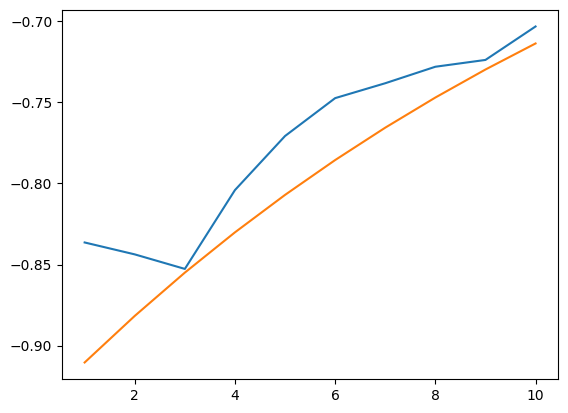

In [16]:
y = np.array([])
Y_1 = np.log(np.array(dim_1))
Y_2 = np.log(np.array(dim_2))
Y_3 = np.log(np.array(dim_3))
Y_4 = np.log(np.array(dim_4))
Y_5 = np.log(np.array(dim_5))
Y_6 = np.log(np.array(dim_6))
Y_7 = np.log(np.array(dim_7))
Y_8 = np.log(np.array(dim_8))
Y_9 = np.log(np.array(dim_9))
Y_10 = np.log(np.array(dim_10))
m, b = np.polyfit(X, Y_1, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_2, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_3, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_4, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_5, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_6, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_7, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_8, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_9, 1)
y = np.append(y, np.array([m]))
m, b = np.polyfit(X, Y_10, 1)
y = np.append(y, np.array([m]))
X_dim = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
Y_dim = -1*np.exp((-.07255*X_dim) - .81806) -.5
plt.figure()
plt.plot(X_dim, y)
plt.plot(X_dim, Y_dim)
plt.show()
m, b = np.polyfit(X_dim, y, 1)

In [17]:
print('test')

test


In [3]:
kronecker = qp.Kronecker(2)
K = kronecker.gen_samples(4)
print(K)

[[0.         0.        ]
 [0.74100883 0.3470695 ]
 [0.48201767 0.69413899]
 [0.2230265  0.04120849]]


In [4]:
kronecker = qp.Kronecker(2)
print(kronecker)

In [12]:
kronecker = Kronecker(2)
K = kronecker.gen_samples(4)
print(K)

[[0.         0.        ]
 [0.41432165 0.62719238]
 [0.82864329 0.25438476]
 [0.24296494 0.88157714]]


In [33]:
10 - np.arange(1,10)

array([9, 8, 7, 6, 5, 4, 3, 2, 1])